In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
import pandas as pd
import evaluate
import ast

In [93]:
api = wandb.Api()

In [94]:
metric = evaluate.combine(["precision", "recall", "accuracy", "f1"])

In [95]:
def download_predictions(run_name: str, invert:bool = False) -> tuple[dict]:
    ret = []

    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()
    runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})

    for run in runs:
        if run.state == 'finished':
            for art in run.logged_artifacts():
                if "test_predictions" in art.name:
                    path = art.download()
                    labels = np.load(path + '/labels.npy')
                    predictions = np.load(path + '/predictions.npy')
                    # Apply softmax to prediction logits using torch
                    predictions_t = torch.tensor(predictions)
                    probs = torch.nn.functional.softmax(predictions_t, dim=-1)
                    predictions = torch.argmax(probs, dim=1, keepdim=True).flatten().numpy()

                    # Invert if desired
                    if invert:
                        predictions = np.abs(predictions - 1)

                    ret.append({
                        'run_name': run_name,
                        'artifact_name': art.name,
                        'predictions': predictions,
                        'labels': labels})
    
    return tuple(ret)

In [96]:
def plot_predictions(predictions: dict):
    conf_mats_ct24 = [confusion_matrix(preds["labels"], preds["predictions"]) for preds in predictions]
    fig, axes = plt.subplots(1, len(conf_mats_ct24), figsize=(15, 5))
    fig.suptitle(predictions[0]["run_name"], fontsize=16)

    if len(conf_mats_ct24) == 1:
        # Wrap in array if single axes so we can iter
        axes = [axes]

    for ax, cm, preds in zip(axes, conf_mats_ct24, predictions):
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(ax=ax)
        ax.title.set_text(preds['artifact_name'])

    plt.tight_layout()
    plt.show()

    metrics = [metric.compute(predictions=preds["predictions"], references=preds["labels"]) for preds in predictions]
    metrics_frame = pd.DataFrame(metrics)
    print(metrics_frame)
    print("--mean--")
    print(metrics_frame.mean())

In [97]:
def get_misclassified_samples(predictions: np.array, data_frame: pd.DataFrame, trunc_data: int | bool = False):
    if trunc_data:
        data_frame = data_frame.head(trunc_data)
    
    # Convert the "class_label" column to integers (Yes -> 1, No -> 0)
    data_frame['class_label'] = data_frame['class_label'].map({'Yes': 1, 'No': 0})
    
    # Retrieve rows where the "class_label" column does not match the predictions
    misclassified_samples = data_frame[data_frame['class_label'] != predictions]
    
    return misclassified_samples

In [122]:
def plot_misclassifications(misclassified: pd.DataFrame, plot_header: str | None = None):
    columns_to_plot = ["topic", "style", "source", "class_label", "sentiment"]

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))

    if plot_header:
        fig.suptitle(plot_header, fontsize=16)

    axes = axes.flatten()

    for idx, col in enumerate(columns_to_plot):
        misclassified[col].value_counts().plot(kind='bar', ax=axes[idx], title=f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
    
    # Handle NER
    ner_counts = {}
    for tags in misclassified['ner'].dropna():
        for t in tags:
            if t in ner_counts:
                ner_counts[t] += 1
            else:
                ner_counts[t] = 1
    
    # Plot NER tag distribution as a histogram in the last subplot
    plt.tight_layout()
    plt.show()

    # Plot NER tag distribution in a separate figure
    if ner_counts:
        # Sort ner_counts by descending value
        sorted_ner = sorted(ner_counts.items(), key=lambda x: x[1], reverse=True)
        ner_tags, ner_values = zip(*sorted_ner)
        plt.figure(figsize=(6, 4))
        plt.bar(ner_tags, ner_values)
        plt.title('NER Tag Distribution')
        plt.xlabel('NER Tag')
        plt.ylabel('Count')
        plt.xticks(rotation=60)
        plt.tight_layout()
        plt.show()
    

    plt.tight_layout()
    plt.show()

In [99]:
from collections import Counter

def intersect_misclassifications(misclassified: list[pd.DataFrame], min_num_misclassified: int) -> pd.DataFrame:
    # Combine all misclassified dataframes into a single dataframe
    combined = pd.concat(misclassified, ignore_index=True)
    
    # Count occurrences of each Sentence_id across all dataframes
    counts = combined['Sentence_id'].value_counts()
    
    # Filter Sentence_ids that appear in at least min_num_misclassified dataframes
    frequent_ids = counts[counts >= min_num_misclassified].index
    
    # Retrieve rows with those Sentence_ids
    result = combined[combined['Sentence_id'].isin(frequent_ids)]

    # Remove duplicate rows based on 'Sentence_id', keeping the first occurrence
    result = result.drop_duplicates(subset='Sentence_id')
    
    return result

def exclusive_misclassifications(misclassified_left: pd.DataFrame, misclassified_right: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    intersection = intersect_misclassifications([misclassified_left, misclassified_right], min_num_misclassified=2)
    exclusive_left = misclassified_left[~misclassified_left['Sentence_id'].isin(intersection['Sentence_id'])]
    exclusive_right = misclassified_right[~misclassified_right['Sentence_id'].isin(intersection['Sentence_id'])]
    
    return exclusive_left, exclusive_right

In [100]:
invert = False
predictions_ct24 = download_predictions("ct24_general_claim_eval", invert=invert)
predictions_ct24_double = download_predictions("ct24_double_general_claim_eval", invert=invert)

wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  


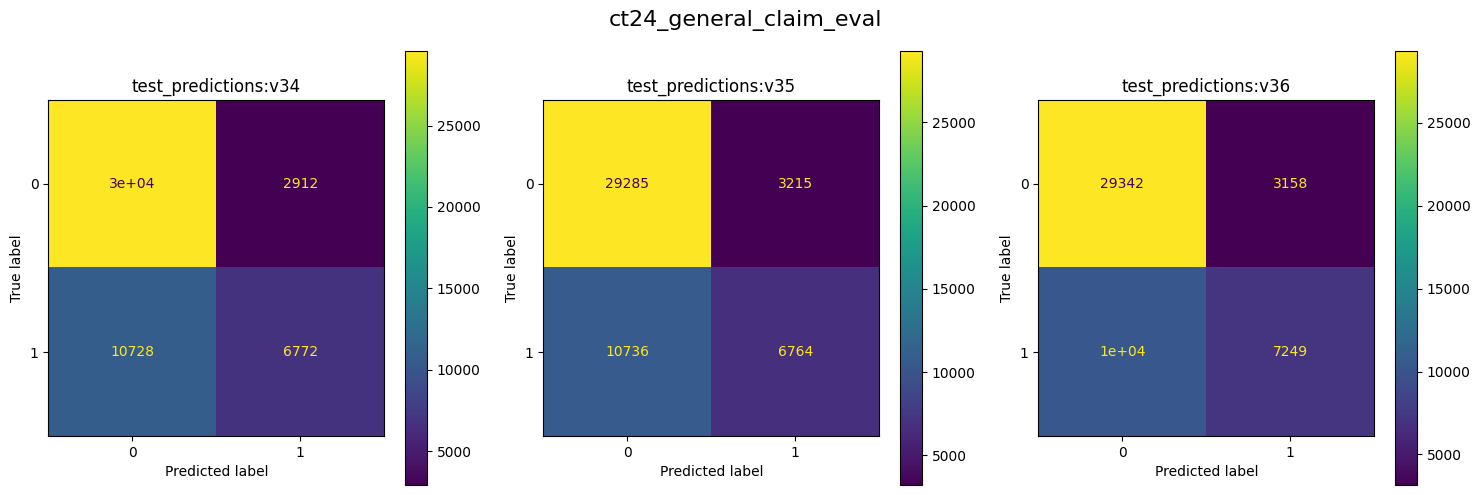

   precision    recall  accuracy        f1
0   0.699298  0.386971   0.72720  0.498234
1   0.677823  0.386514   0.72098  0.492303
2   0.696550  0.414229   0.73182  0.519511
--mean--
precision    0.691224
recall       0.395905
accuracy     0.726667
f1           0.503350
dtype: float64


In [101]:
plot_predictions(predictions_ct24)

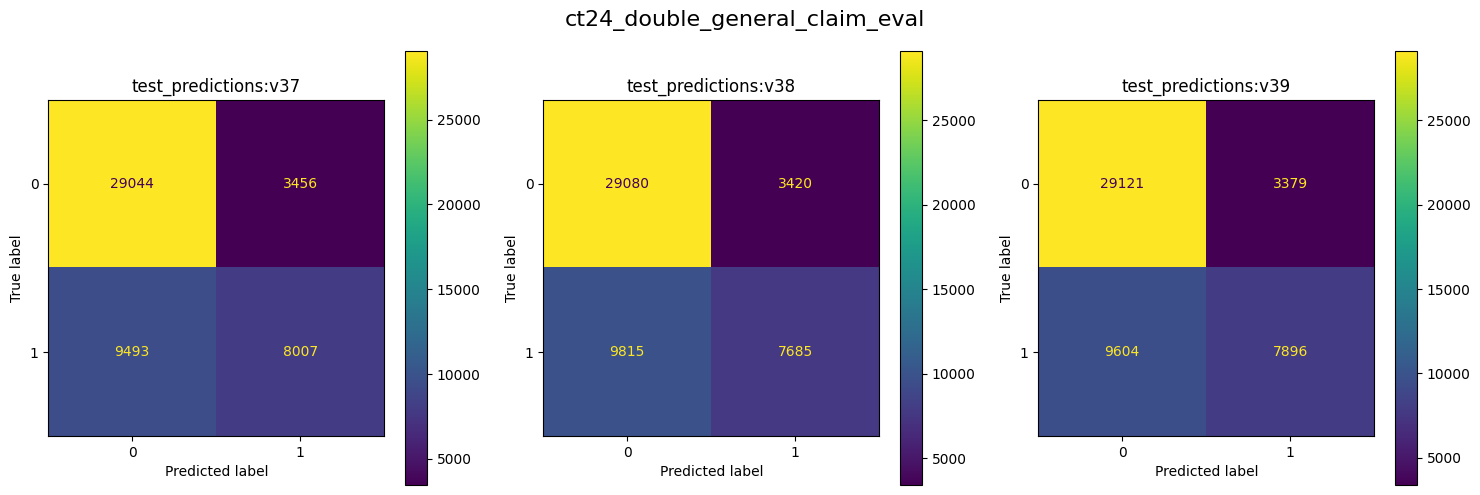

   precision    recall  accuracy        f1
0   0.698508  0.457543   0.74102  0.552912
1   0.692031  0.439143   0.73530  0.537319
2   0.700310  0.451200   0.74034  0.548810
--mean--
precision    0.696950
recall       0.449295
accuracy     0.738887
f1           0.546347
dtype: float64


In [102]:
plot_predictions(predictions_ct24_double)

In [103]:
api = wandb.Api()
artifact = api.artifact("redstag/thesis/general_claim_tagged:latest")
eval_df = pd.read_csv(f"{artifact.download()}/tagged_data.csv")

wandb: Downloading large artifact general_claim_tagged:latest, 64.53MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (114.9MB/s)


In [104]:
# Convert the NER string to a list
eval_df['ner'] = eval_df['ner'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)

In [105]:
misclassified_ct24 = [get_misclassified_samples(preds["predictions"], eval_df, trunc_data=len(preds["predictions"])) for preds in predictions_ct24]
misclassified_ct24_double = [get_misclassified_samples(preds["predictions"], eval_df, trunc_data=len(preds["predictions"])) for preds in predictions_ct24_double]

/tmp/ipykernel_5891/4145902517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['class_label'] = data_frame['class_label'].map({'Yes': 1, 'No': 0})
/tmp/ipykernel_5891/4145902517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['class_label'] = data_frame['class_label'].map({'Yes': 1, 'No': 0})
/tmp/ipykernel_5891/4145902517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [106]:
majority_misclassified_ct24 = intersect_misclassifications(misclassified_ct24, min_num_misclassified=1)
majority_misclassified_ct24_double = intersect_misclassifications(misclassified_ct24_double, min_num_misclassified=1)

In [107]:
exclusive_ct24, exclusive_ct24_double = exclusive_misclassifications(majority_misclassified_ct24, majority_misclassified_ct24_double)

In [111]:
exclusive_ct24['ner'][48][0]

'MONEY'

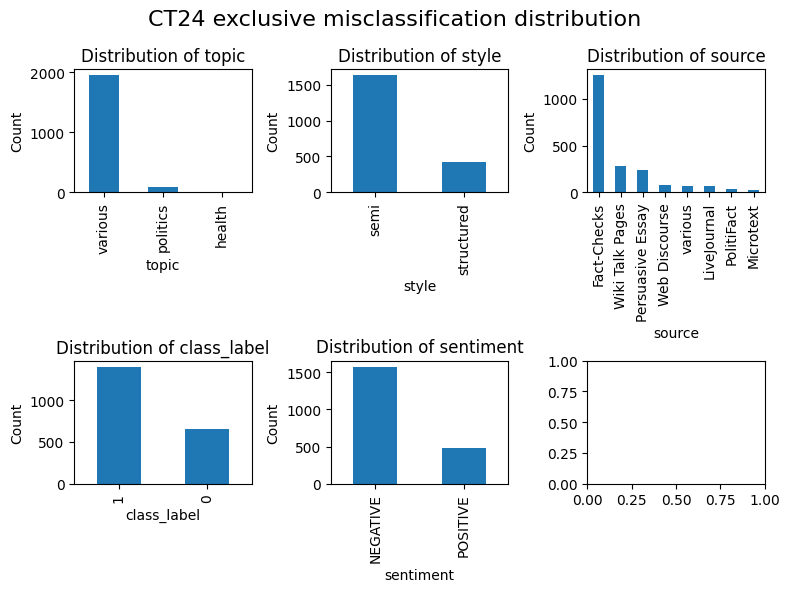

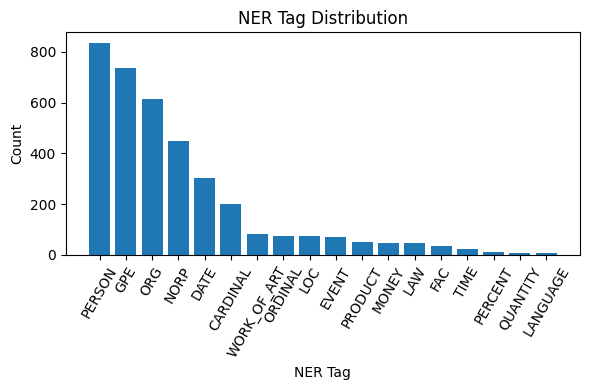

<Figure size 640x480 with 0 Axes>

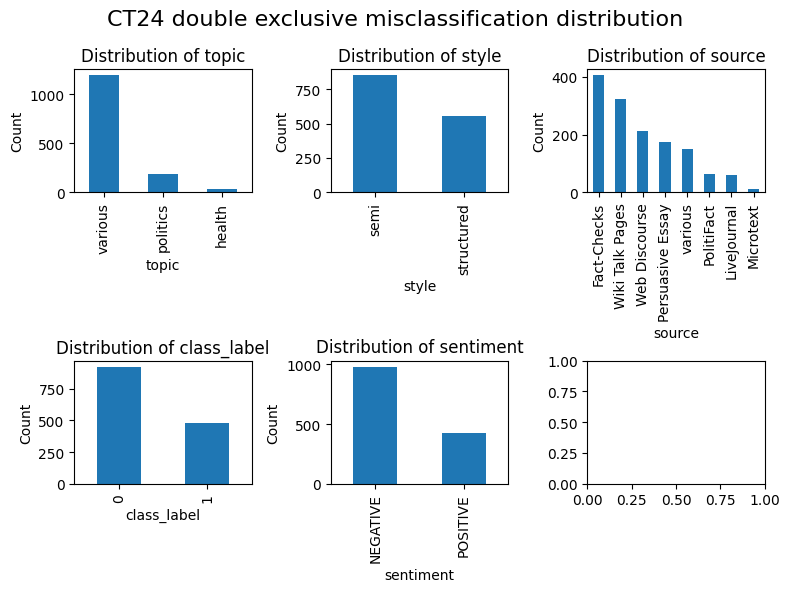

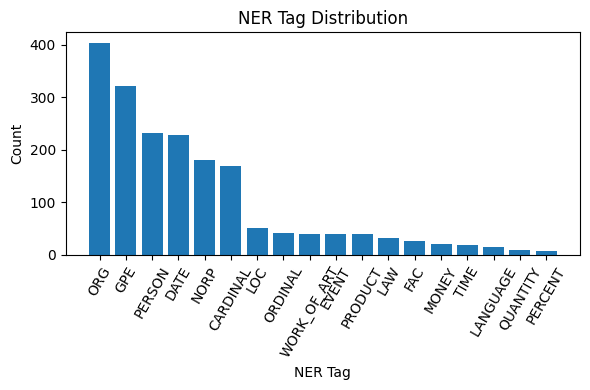

<Figure size 640x480 with 0 Axes>

In [123]:
plot_misclassifications(exclusive_ct24, "CT24 exclusive misclassification distribution")
plot_misclassifications(exclusive_ct24_double, "CT24 double exclusive misclassification distribution")